In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import mean
import scipy
from scipy.integrate import quad
import scipy.integrate as integ
from scipy.optimize import curve_fit

In [2]:
data=pd.read_hdf('/home/dorazio/ABALONE/data_ABALONE_area11.h5')

In [3]:
def gauss(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2 / (2.*sigma**2))
def expo(x, a, tau):
    return a*np.exp(-x/tau)
def landau(x,a,loc,scale):
    return 1.6*a*np.exp(-( (x-loc)/scale + np.exp(-(x-loc)/scale) )/2)
def expgauss(x,a,mu,sigma,tau):
    return a/2 * np.exp((sigma**2-2*x*tau)/(2*tau**2))*(1-scipy.special.erf((sigma**2+tau*(mu-x))/(np.sqrt(2)*sigma*tau) ))

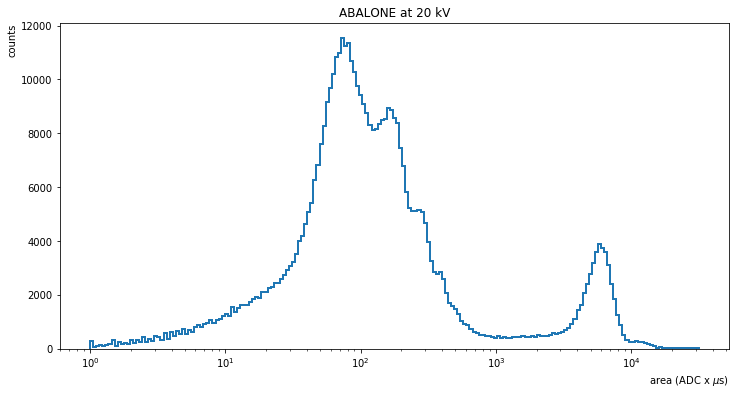

<Figure size 864x432 with 0 Axes>

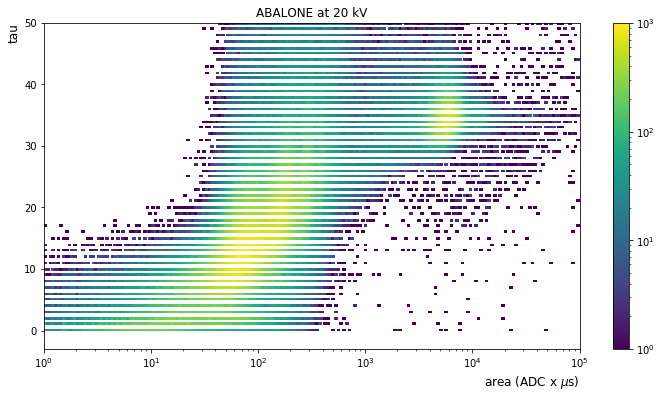

In [14]:
import utility as psu
fvolt = 20
psu.plot_area_spectrum(data['area'], bins=200, logx=True, logy=False, volts=fvolt,low=0, high=4.5)
psu.plot_area_tau(data['area'],data['tau'],bins=200,volts=fvolt,low=0., high=5,low2=-3, high2=50)

# Fit del primo picco expgauss+landau

In [92]:
def noise_spectrum(x,a1,x1,sigma1,a2,x2,sigma2,a3,x3,sigma3,a4,x4,sigma4,a5,x5,sigma5):
    return landau(x,a1,x1,sigma1)+gauss(x,a2,x2,sigma2)+gauss(x,a3,x3,sigma3)+gauss(x,a4,x4,sigma4)+gauss(x,a5,x5,sigma5)
    #return expo(x,a0,tau0)+landau(x,a1,x1,sigma1)+gauss(x,a2,x2,sigma2)+gauss(x,a3,x3,sigma3)+gauss(x,a4,x4,sigma4)+gauss(x,a5,x5,sigma5)

def fit_spectrum_low(area, bins = 200, volts = 10, ledv = 3, low = 0, high = 750,fit_lim=600,save = False):
    
    area_space = np.linspace(low,high, bins)
    h, t = np.histogram(area, bins=area_space)
    tc = (t[:-1] + t[1:])/2.
    #a = plt.hist(area,bins=area_space,histtype='step',lw=2,density=False, label = 'data')
    
    #idx1 = np.where(t>spe_div)[0][0]
    imax = np.argmax(h)
    x1, hmax = t[imax], h[imax]
    idx = np.where(h>hmax/1.5) # fwhm=ampiezza a metà altezza
    ilo, ihi = idx[0][0], idx[0][-1]
    sig = (t[ihi]-t[ilo]) / 2.355
    print(sig)
    #guess = (  5000, 180,  5000, x1,   30, 1000, 170, 30, 200, 280, 30, 100, 400, 30, 50, 500, 30)
    #bounds = ([4800, 115, 4000, x1-10, 10,  500, 160, 20, 100, 270, 20,  50, 390, 20, 10, 450, 20],
    #          [6000, 200, 6000, x1+10, 40, 2000, 180, 40, 500, 290, 40, 200, 410, 50, 80, 550, 50])
    guess = (  hmax,     x1,    sig, 2000, 170, sig,  800, 280, sig, 300, 400, sig, 150, 500, sig)
    bounds = ([hmax*0.9, x1-sig, 10,  500, 160,  20,  500, 270,  20, 200, 390,  20, 100, 495, 20],
              [hmax*1.1, x1+sig, 40, 3000, 180,  40, 1000, 290,  40, 400, 410,  50, 200, 505, 50])
    
    #fit
    popt, pcov = curve_fit(noise_spectrum, tc[:fit_lim], h[:fit_lim], p0 = guess, bounds = bounds)
    perr = np.sqrt(np.diag(pcov))
    plt.figure(figsize=(12,6))
    plt.plot(tc, h,label=f'data')
    plt.plot(t, noise_spectrum(t, *popt),ls='--', label = 'spectrum fit')
    #expgauss_spe = lambda x : noise_spectrum(x, *popt[:4])
    #landau_int = lambda x : gauss(x, *popt[4:])
    #plt.plot(t, expo(t, *popt[:2]),label=f'noise')
    plt.plot(t, landau(t, *popt[:3]),label=f'p1: {popt[1]:.1f} $\pm$ {popt[2]:.1f} (ADC x 10ns)')
    plt.plot(t, gauss(t, *popt[3:6]),label=f'p2: {popt[4]:.1f} $\pm$ {popt[5]:.1f} (ADC x 10ns)')
    plt.plot(t, gauss(t, *popt[6:9]),label=f'p3: {popt[7]:.1f} $\pm$ {popt[8]:.1f} (ADC x 10ns)')
    plt.plot(t, gauss(t, *popt[9:12]),label=f'p4: {popt[10]:.1f} $\pm$ {popt[11]:.1f} (ADC x 10ns)')
    plt.plot(t, gauss(t, *popt[12:15]),label=f'p5: {popt[13]:.1f} $\pm$ {popt[14]:.1f} (ADC x 10ns)')
    #plt.plot(t, noise_spectrum(t, *guess), label = 'guess')
    #plt.title(f'ABALONE at {volts} kV - LED at {ledv:.1f} V')
    plt.xlabel('area (ADC x 10ns)',fontsize=10)
    plt.ylabel('conteggi',fontsize=10)
    plt.tick_params(axis='x',labelsize=10)
    plt.tick_params(axis='y',labelsize=10)
    plt.legend()
    plt.ylim(1e1,1e4)
    #plt.xlim(-10,200)
    plt.yscale('log')
    plt.savefig('plots/Fit_low_spectrum.png',dpi=800)
    ################
    """
    expo_noise = lambda x : expo(x, *popt[:2])
    
    plt.figure(figsize=(8,4.5))
    plt.plot(tc, h-expo_noise(tc),label=f'data w/o noise')
    plt.plot(0,0)
    plt.plot(0,0)
    plt.plot(t, landau(t, *popt[2:5]),label=f'p1: {popt[3]:.1f} $\pm$ {popt[4]:.1f} (ADC x 10ns)')
    plt.plot(t, gauss(t, *popt[5:8]),label=f'p2: {popt[6]:.1f} $\pm$ {popt[7]:.1f} (ADC x 10ns)')
    plt.plot(t, gauss(t, *popt[8:11]),label=f'p3: {popt[9]:.1f} $\pm$ {popt[10]:.1f} (ADC x 10ns)')
    plt.plot(t, gauss(t, *popt[11:14]),label=f'p4: {popt[12]:.1f} $\pm$ {popt[13]:.1f} (ADC x 10ns)')
    plt.plot(t, gauss(t, *popt[14:]),label=f'p5: {popt[15]:.1f} $\pm$ {popt[16]:.1f} (ADC x 10ns)')
    plt.xlabel('area (ADC x 10ns)',fontsize=10)
    plt.ylabel('conteggi',fontsize=10)
    plt.tick_params(axis='x',labelsize=10)
    plt.tick_params(axis='y',labelsize=10)
    plt.yscale('log')
    plt.ylim(1,1e4)
    plt.xlim(20,high)
    plt.legend(fontsize=10)
    plt.savefig('plots/Fit_low_spectrum_no_noise.png',dpi=800)
    """
    return popt

20.237309076965683


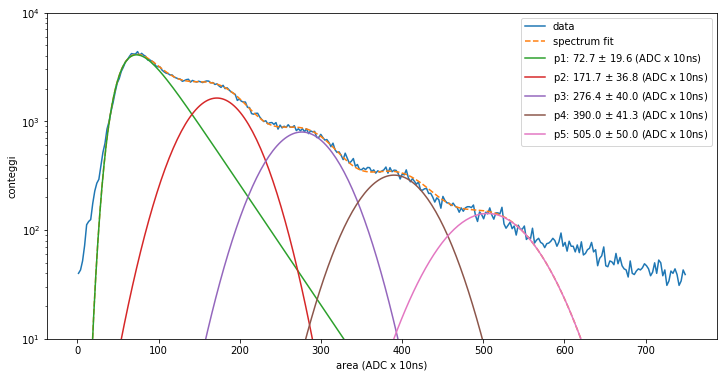

In [95]:
area = data['area'][data['tau']>12]
parlow = fit_spectrum_low(area, low = 0, high = 750, bins = 300,fit_lim=510)

In [106]:
def spe_spectrum(x,a1,mu1,sigma1,a2,mu2,sigma2,tau2):
    return gauss(x,a1,mu1,sigma1)+ expgauss(x,a2,mu2,sigma2,tau2)
def all_fit(x,a1,mu1,sigma1,a2,mu2,sigma2,tau2,a0,tau0,a3,x3,sigma3,a4,x4,sigma4,a5,x5,sigma5,a6,x6,sigma6,a7,x7,sigma7):
    return spe_spectrum(x,a1,mu1,sigma1,a2,mu2,sigma2,tau2)+noise_spectrum(x,a0,tau0,a3,x3,sigma3,a4,x4,sigma4,a5,x5,sigma5,a6,x6,sigma6,a7,x7,sigma7)
def fit_spe_spectrum(area, parlow, bins = 200, low = 0, high = 100, spe_div = 3000,fitrange=(500,9000),
                     rebin = 10, save = False):
    area_space = np.linspace(low,high, bins)
    h, t = np.histogram(area, bins=area_space)
    tc = (t[:-1] + t[1:])/2.
    hn = h-noise_spectrum(tc, *parlow)
    tt, hh = [], []
    for ii in range(int(bins/rebin)):
        idx = rebin*ii
        tt = np.append(tt,np.mean(tc[idx:idx+rebin]))
        hh = np.append(hh,np.sum(hn[idx:idx+rebin]))
    
    #SPE guess
    idx1 = np.where(tt>spe_div)[0][0]
    imax = np.argmax(hh[idx1:])+idx1
    mu, hmax = tt[imax], hh[imax]
    idx = np.where(hh[idx1:]>hmax/2) # fwhm 
    ilo, ihi = idx[0][0], idx[0][-1]
    sig = (tt[ihi]-tt[ilo]) / 2.355
    #NRBE guess
    imax0 = np.argmax(hh[:idx1])
    mu0, hmax0 = tt[imax0], hh[imax0]
    idx0 = np.where(hh[:idx1]>hmax0/1.5) 
    ilo, ihi = idx0[0][0], idx0[0][-1]
    sig0 = (tt[ihi]-t[ilo]) / 2.355
    print(sig)
    #guess = (hmax, mu, sig, hmax0, mu0, sig0, hmax/2, 20, 5)
    guess = (      hmax,     mu,     sig, hmax0*2, mu0/2, 400, 1500)
    bounds = ([hmax*0.9, mu-sig, sig*0.8,      50,    10, 100, 600],
              [1.1*hmax, mu+sig, sig*1.2,    4000,  1500, 500, 5000])
    #fit 
    frange = (np.where(tt>fitrange[0])[0][0],np.where(tt>fitrange[1])[0][0])
    #popt, pcov = curve_fit(spe_spectrum, tt[frange[0]:frange[1]], hh[frange[0]:frange[1]], p0 = guess, bounds = bounds)
    #perr = np.sqrt(np.diag(pcov))
    popt=guess
    gauss_spe = lambda x : gauss(x, *popt[:3])
    expgauss_int = lambda x : expgauss(x, *popt[3:])
    spe_int = lambda x : spe_spectrum(x, *popt)
    nspe, spe_er = integ.quad(gauss_spe,0,t[-1])
    #print('nspe',nspe)
    nbs, bs_er = integ.quad(expgauss_int,0,t[-1])
    #print('nbs',nbs)
    ntot, tot_er  = integ.quad(spe_int,0,t[-1])
    
    plt.figure(figsize=(8,4.5))
    #plt.figure(figsize=(12,6))
    plt.plot(tt, hh, label=f'data')
    plt.plot(tt, spe_spectrum(tt, *popt),ls='--', label = 'spectrum fit')
    plt.plot(tt, gauss(tt, *popt[:3]),label=f'SPE at {popt[1]:.1f} $\pm$ {popt[2]:.1f}')
    plt.plot(tt, expgauss(tt, *popt[3:]),label=f'{nbs/(nspe+nbs)*100:.1f}% Non-Returning')
    #plt.plot(tt, spe_spectrum(tt, *guess), label = 'guess')
    plt.xlabel('area (ADC x 10ns)',fontsize=12)
    plt.ylabel('conteggi',fontsize=12)
    plt.tick_params(axis='x',labelsize=12)
    plt.tick_params(axis='y',labelsize=12)
    plt.legend(fontsize=12)
    #plt.yscale('log')
    plt.ylim(0,None)
    plt.savefig('plots/Fit_SPE_spectrum.png',dpi=800)
    return popt#, nspe, nbs

1271.01839154056


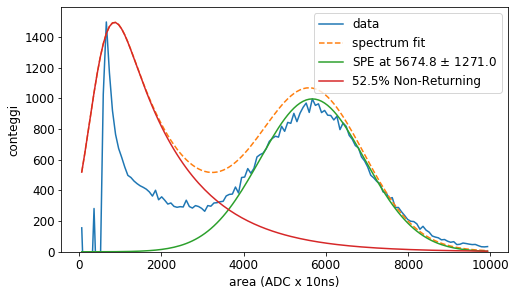

In [108]:
popt=fit_spe_spectrum(area,parlow, low = 25, high = 10000, bins = 4000,rebin=30)

In [509]:
def plot_spectrum(area, par,parlow, bins = 200, low = 0, high = 100, scale=1,save = False):
    area_space = np.linspace(low,high, bins)
    h, t = np.histogram(area, bins=area_space)
    #plt.figure(figsize=(8,4.5))
    plt.figure(figsize=(12,6))
    tc = (t[:-1] + t[1:])/2.
    a1 = plt.hist(area,bins=area_space,histtype='step',lw=2,density=False)
    
    plt.plot(t, scale*all_fit(t, *par,*parlow), label = 'spectrum fit')
    #plt.plot(t, gauss(t, *popt[:3]),label=f'SPE at {popt[1]:.2f} $\pm$ {popt[2]:.2f} ADC x $\mu$s')
    #plt.plot(t, expgauss(t, *popt[3:]),label=f'{nbs/(nspe+nbs)*100:.1f}% Non-Returning')
    #plt.plot(t, noise_spectrum(t, *parlow), label = 'noise spectrum')
    plt.xlabel('area (ADC x $\mu$s)',ha='right',x=1,fontsize=12)
    plt.ylabel('counts',ha='right',y=1,fontsize=12)
    plt.tick_params(axis='x',labelsize=12)
    plt.tick_params(axis='y',labelsize=12)
    plt.legend(fontsize=12)
    #plt.yscale('log')
    plt.ylim(1,3e2)
    if save: plt.savefig('plots/SPEfit.png',dpi=800)

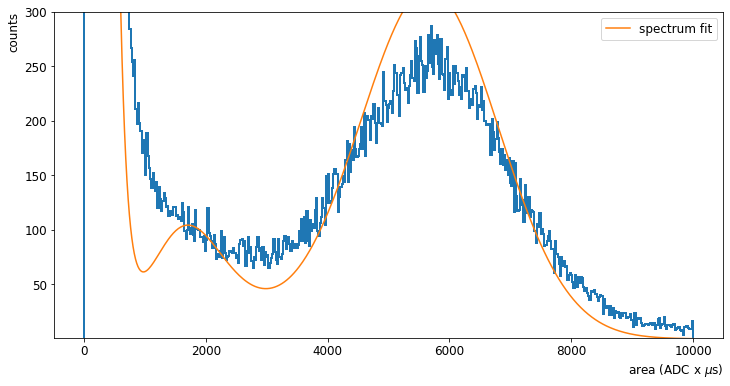

In [510]:
plot_spectrum(data['area'], popt,parlow,scale=7,low = 0, high = 10000, bins = 500)

# Fit del primo picco expgauss+gauss

In [192]:
def expgauss(x,a,x0,tau):
    return a * 1/2 * np.exp((1+2*tau*x0-2*tau*x)/(2*tau**2))* scipy.special.erfc((1/tau+x0-x)/np.sqrt(2))

def gauss(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2 / (2.*sigma**2))

def gauss_exp(x,a1,mu1,sigma1,a2,x0,tau):
    return gauss(x,a1,mu1,sigma1)+ expgauss(x,a2,x0,tau)

def fit_gauss_exp(area, bins = 200, volts = 10, ledv = 3, low = 0, high = 10000, spe_div = 2500, sig2=8, save = False):
    area_space = np.linspace(low,high, bins)
    h, t = np.histogram(area, bins=area_space) #h="altezza" della colonna dell'istogramma(sarebbe il valore sull'asse y) e t=estremo dell'intervallo corrispondente a h (sarebbe il valore sull'asse x) 
    plt.figure(figsize=(15,7.5))
    tc = (t[:-1] + t[1:])/2.  #tc= individua il punto centrale dell'intervallo della colonna dell'istogramma. In questo modo a ogni h corrisponde un solo tc
    a = plt.hist(area,bins=area_space,histtype='step',lw=2,density=False)
    
    idx1 = np.where(t>spe_div)[0][0]  #spe_div è il punto in cui decidiamo che deve iniziare il fit
    imax = np.argmax(h[idx1:])+idx1
    mu, hmax = t[imax], h[imax]
    idx = np.where(h[idx1:]>hmax/2) # fwhm=ampiezza a metà altezza
    ilo, ihi = idx[0][0], idx[0][-1]
    sig = (t[ihi]-t[ilo]) / 2.355
    
    guess = (hmax, mu, sig-20, 6600, 1, 25)#, hmax/2, 25, 5)
    
    print(hmax,mu,sig)
    
    bounds = ([hmax-30, mu-10, 0, 6000, 0, 2],
              [hmax+30, mu+10, sig-10, 7000, 5, 30])
    #fit 
    
    
    popt, pcov = curve_fit(spe_spectrum_gauss_exp, tc[idx1:], h[idx1:], p0 = guess, bounds = bounds) #6 parametri ottimali che si ottengono con il fit: i primi 3 sono relativi alla gaussiana e gli ultimi 3 all'esponenziale convoluta con una gaussiana
    perr = np.sqrt(np.diag(pcov)) #stima degli errori
    print('popt',popt)
    
    plt.plot(t, gauss_exp(t, *popt), label = 'spectrum fit') #funzione che si ottiene con il fit  utilizzando i popt
    
    gauss_spe = lambda x : gauss(x, *popt[:3])  #gaussiana ottenuta considerando i primi 3 parametri ottimali
    nspe, spe_er = integ.quad(gauss_spe,0,t[-1])
    #print('nspe',nspe)
    plt.plot(t, gauss(t, *popt[:3]),label='Gaussiana')
    
    
    gauss_bs = lambda x : expgauss(x, *popt[3:])  #esponenziale convoluta con gaussiana ottenuta considerando gli ultimi 3 parametri ottimali
    nbs, bs_er = integ.quad(gauss_bs,0,t[-1])
    #print('nbs',nbs)
    plt.plot(t, expgauss(t, *popt[3:]),label=f'Expgauss') # - {nbs/(nspe+nbs)*100:.1f}% Non-Returning')
    
    
    spe_int = lambda x : gauss_exp(x, *popt)  #funzione ottenuta dalla somma della gaussiana e dell'esponenziale convoluta con una gaussiana
    plt.plot(t, gauss_exp(t, *guess), label = 'guess')
    
    #plt.title(f'ABALONE at {volts} kV - LED at {ledv:.1f} V')
    plt.xlabel('Scala lineare - area (ADC x 10ns)')
    plt.ylabel('Scala lineare - conteggi')
    plt.tick_params(axis='x',labelsize=12)
    plt.tick_params(axis='y',labelsize=12)
    plt.legend(fontsize=12)
    #plt.yscale('log')
    #plt.xlim(-10,200)
    if save: plt.savefig('fit_Gauss_Exp_data11.png',dpi=800)
    return popt[1], popt[2], nspe, nbs

7922 62.70903010033445 43.66998274503121
popt [7.89200000e+03 7.21833398e+01 3.36699827e+01 6.83660491e+03
 2.78338255e+00 1.71714864e+01]


(72.18333979360317, 33.669982745031206, 655397.9295689425, 117389.25524314123)

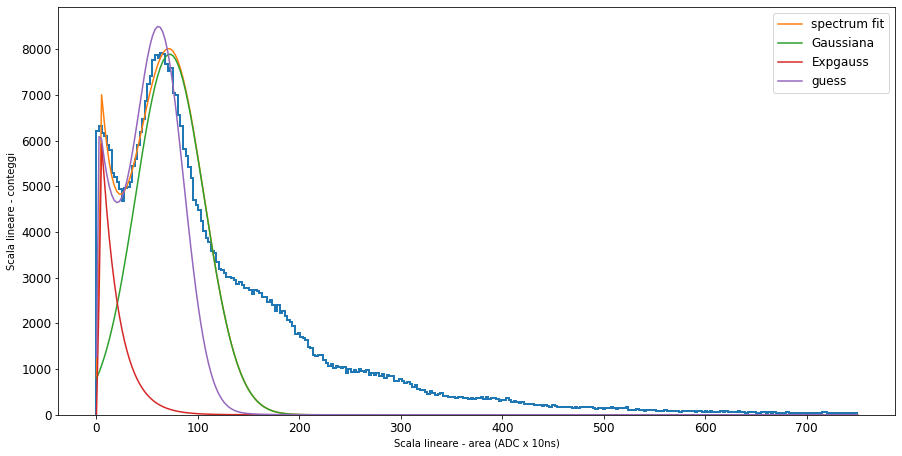

In [193]:
fit_gauss_exp(data['area'], volts = 24, low = 0, high = 750, bins = 300, spe_div=0)